# Record-wise classification

For each record n frames where generated, resulting in n scalograms

The classification output will result in a classification probability per record

Their average will be computed and that will be the record prediction

The probability can be turned into a class if the average exceeds a threshold (0.5) for example


In [118]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, recall_score, accuracy_score, precision_score, confusion_matrix as cm, ConfusionMatrixDisplay

### CV Results

In [119]:
# Function that loads the CV results and concats 

def load_pickle_df(pickle_list):
    df_list = []
    for p in pickle_list:
        with open (p, 'rb') as f:
            df = pickle.load(f)
        df_list.append(df)
    df = pd.concat(df_list, ignore_index = True)
    df['params_str'] = df['params'].apply(lambda x: str(x))
    return df



In [120]:
def loss_graph(avg_train_loss, avg_val_loss, fig_name='loss.png'):
    # Create an array with the epoch numbers
    epochs = np.arange(1, len(avg_train_loss) + 1)

    # Plot the average training and validation loss per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_loss, marker='o', label='Training Loss')
    plt.plot(epochs, avg_val_loss, marker='o', label='Validation Loss')
    plt.title('Average Training and Validation Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    #plt.grid(True)
    plt.grid(axis='y', linestyle='-')
    plt.savefig(fig_name, dpi=300)
    plt.plot()
    plt.close()

In [121]:
def acc_graph(avg_train_acc, avg_val_acc, fig_name='acc.png'):
    # Create an array with the epoch numbers
    epochs = np.arange(1, len(avg_train_acc) + 1)

    # Plot the average training and validation loss per epoch
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, avg_train_acc, marker='o', label='Training Accuracy')
    plt.plot(epochs, avg_val_acc, marker='o', label='Validation Accuracy')
    plt.title('Average Training and Validation Accuracy per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.legend()
    #plt.grid(True)
    plt.grid(axis='y', linestyle='-')
    plt.savefig(fig_name, dpi=300)
    plt.plot()
    plt.close()

In [122]:
gs_cols = ['params_str', 'train_auc', 'test_auc', 'train_f1', 'test_f1']

In [123]:
def record_wise_probability(groups, real_values, predictions):
    group_real_sum = {}
    group_pred_sum = {}
    group_count = {}

    for group, real_value, prediction in zip(groups, real_values, predictions):
        if group not in group_real_sum:
            group_real_sum[group] = 0
            group_pred_sum[group] = 0
            group_count[group] = 0
        group_real_sum[group] += real_value
        group_pred_sum[group] += prediction
        group_count[group] += 1
    group_real_avg = {group: int(group_real_sum[group] / group_count[group]) for group in group_real_sum}
    group_pred_avg = {group: group_pred_sum[group] / group_count[group] for group in group_pred_sum}

    return group_real_avg, group_pred_avg

def get_record_wise_results(pcg_other_results):
    # For each gridsearch param, determine the average prediction per subject
    # Calculate the average PR AUC per FOLD
    # Model with highest PR AUC is selected
    pcg_other_results['record_pr_auc'] = 0
    pcg_other_results['record_true_values'] =0
    pcg_other_results['record_wise_probs'] =0
    pcg_other_results['record_f1_score'] = 0
    pcg_other_results['record_accuracy'] = 0
    pcg_other_results['record_precision'] = 0
    pcg_other_results['record_recall'] = 0
    pcg_other_results['confusion_matrix'] = 0
    pcg_other_results['record_true_values'] = pcg_other_results['record_true_values'].astype('object')
    pcg_other_results['record_wise_probs'] = pcg_other_results['record_wise_probs'].astype('object')
    pcg_other_results['confusion_matrix'] = pcg_other_results['confusion_matrix'].astype('object')
    for index, value in pcg_other_results.iterrows():
        true_values, record_wise_probs =  record_wise_probability(value['test_group'], value['y_true_val'],value['prediction_test'].ravel().tolist())
        true_values_list = list(true_values.values())
        record_wise_probs_list = list(record_wise_probs.values())
        pcg_other_results.at[index, 'record_true_values']=true_values_list
        pcg_other_results.at[index, 'record_wise_probs']=record_wise_probs_list
        pcg_other_results.loc[index, 'record_pr_auc'] = average_precision_score(true_values_list, record_wise_probs_list)
        pcg_other_results.loc[index, 'record_roc_auc'] = roc_auc_score(true_values_list, record_wise_probs_list)
        # Calculate F1-score (binary), accuracy, precision and recall
        pred_binary = [1 if prob > 0.5 else 0 for prob in record_wise_probs_list]
        pcg_other_results.loc[index, 'record_f1_score'] = f1_score(true_values_list, pred_binary)
        pcg_other_results.loc[index, 'record_accuracy'] = accuracy_score(true_values_list, pred_binary)
        pcg_other_results.loc[index, 'record_precision'] = precision_score(true_values_list, pred_binary)
        pcg_other_results.loc[index, 'record_recall'] = recall_score(true_values_list, pred_binary)
        
        conf_mat = cm(true_values_list, pred_binary)
        pcg_other_results.at[index, 'confusion_matrix']=conf_mat
    return pcg_other_results
    
    

## BASELINE - PCG

In [124]:
pcg_baseline_results = ['pcg25_09_2023__14_01_17pcg_scratch_vgg.pkl','pcg25_09_2023__14_23_11pcg_scratch_vgg.pkl','pcg25_09_2023__14_44_13pcg_scratch_vgg.pkl','pcg19_09_2023__13_28_16pcg_scratch_vgg.pkl', 'pcg19_09_2023__13_06_01pcg_scratch_vgg.pkl', 'pcg19_09_2023__12_44_05pcg_scratch_vgg.pkl']

pcg_baseline_df = load_pickle_df(pcg_baseline_results)
pcg_full_info = pcg_baseline_df.copy()
pcg_baseline_df = pcg_baseline_df[gs_cols]

pcg_baseline_summary = pcg_baseline_df.groupby(['params_str']).mean()
pcg_full_info=pcg_full_info[pcg_full_info['params_str'] == pcg_baseline_summary.index[0]]

pcg_baseline_summary

,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': None}",0.809392,0.625998,0.851872,0.829359
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': None}",0.776267,0.577788,0.708974,0.604532
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': None}",0.690910,0.573849,0.831825,0.801209
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': None}",0.664380,0.539945,0.696831,0.643279
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': None}",0.663050,0.606983,0.826426,0.824999
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': None}",0.603568,0.563385,0.478182,0.495350


In [125]:
pcg_full_info['loss'] = pcg_full_info['loss'].apply(np.array)
pcg_full_info['epoch_val_losses'] = pcg_full_info['epoch_val_losses'].apply(np.array)
pcg_full_info['acc_train'] = pcg_full_info['acc_train'].apply(np.array)
pcg_full_info['acc_val'] = pcg_full_info['acc_val'].apply(np.array)

In [126]:
avg_loss = np.mean(pcg_full_info['loss'].to_list(), axis=0)
avg_val_loss = np.min(pcg_full_info['epoch_val_losses'].to_list(), axis=0)
avg_acc_train = np.mean(pcg_full_info['acc_train'].to_list(), axis=0)
avg_acc_val = np.mean(pcg_full_info['acc_val'].to_list(), axis=0)


loss_graph(avg_loss, avg_val_loss, 'pcg_baseline_loss.png')

acc_graph(avg_acc_train, avg_acc_val, 'pcg_baseline_acc.png' )

## BASELINE - ECG

In [127]:
ecg_baseline_results = ['ecg_scratch25_09_2023__13_41_20ecg_scratch_vgg.pkl','ecg_scratch25_09_2023__13_19_32ecg_scratch_vgg.pkl','ecg_scratch25_09_2023__12_56_59ecg_scratch_vgg.pkl', 'ecg_scratch18_09_2023__21_15_56ecg_scratch_vgg.pkl', 'ecg_scratch18_09_2023__20_53_14ecg_scratch_vgg.pkl', 'ecg_scratch18_09_2023__20_31_52ecg_scratch_vgg.pkl']

ecg_baseline_df = load_pickle_df(ecg_baseline_results)

ecg_full_info = ecg_baseline_df.copy()
ecg_baseline_df = ecg_baseline_df[gs_cols]

ecg_baseline_summary = ecg_baseline_df.groupby(['params_str']).mean().sort_values('test_auc', ascending = False).round(3)




ecg_full_info=ecg_full_info[ecg_full_info['params_str'] == ecg_baseline_summary.index[0]]

ecg_baseline_summary

,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': None}",0.993,0.875,0.962,0.863
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': None}",0.982,0.800,0.945,0.815
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': None}",0.827,0.745,0.660,0.590
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': None}",0.839,0.734,0.851,0.811
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': None}",0.878,0.707,0.839,0.753
"{'batch_size': 32, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': None}",0.847,0.674,0.869,0.806


In [128]:
ecg_full_info['loss'] = ecg_full_info['loss'].apply(np.array)
ecg_full_info['epoch_val_losses'] = ecg_full_info['epoch_val_losses'].apply(np.array)
ecg_full_info['acc_train'] = ecg_full_info['acc_train'].apply(np.array)
ecg_full_info['acc_val'] = ecg_full_info['acc_val'].apply(np.array)

In [177]:
avg_loss = np.mean(ecg_full_info['loss'].to_list(), axis=0)
avg_val_loss = np.mean(ecg_full_info['epoch_val_losses'].to_list(), axis=0)
avg_acc_train = np.mean(ecg_full_info['acc_train'].to_list(), axis=0)
avg_acc_val = np.mean(ecg_full_info['acc_val'].to_list(), axis=0)



In [178]:
loss_graph(avg_loss, avg_val_loss, 'ecg_baseline_loss.png')

acc_graph(avg_acc_train, avg_acc_val, 'ecg_baseline_acc.png' )

## PCG - ONLY FINETUNED (Setting 3)

In [131]:
pcg_other_results = ['physionet2016_bcdef25_09_2023__18_41_40cv_vgg.pkl', 'physionet2016_bcdef25_09_2023__21_01_16cv_vgg.pkl','physionet2016_bcdef13_09_2023__21_42_15cv_vgg.pkl','physionet2016_bcdef13_09_2023__18_42_42cv_vgg.pkl', 'physionet2016_bcdef13_09_2023__16_26_48cv_vgg.pkl', 'physionet2016_bcdef16_09_2023__07_21_55cv_vgg.pkl']


pcg_other_results_df = load_pickle_df(pcg_other_results)

pcg_other_results_df = pcg_other_results_df[gs_cols]

pcg_other_results_summary = pcg_other_results_df.groupby(['params_str']).mean().sort_values('test_auc', ascending = False).round(3)

pcg_other_results_summary



,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': True}",0.996,0.969,0.853,0.730
"{'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.999,0.967,0.948,0.673
"{'batch_size': 32, 'epochs': 40, 'optimizer': 'adam', 'learning_rate': 5e-07, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.996,0.961,0.918,0.678
"{'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 5e-07, 'dropout': 0.5, 'neurons': 128, 'class_weights': True}",0.986,0.956,0.800,0.696
"{'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 5e-07, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.990,0.955,0.860,0.639


## ECG - ONLY FINETUNED (setting 3)

In [132]:
ecg_2017_results=ecg_2017_results_pickle_ft = ['physionet2017_ecg_scalograms26_09_2023__19_37_57_vgg.pkl', 'physionet2017_ecg_scalograms11_09_2023__01_36_36_vgg.pkl', 'physionet2017_ecg_scalograms13_09_2023__13_11_27test_results_vgg.pkl']

ecg_2017_results_df = load_pickle_df(ecg_2017_results)

ecg_2017_results_df = ecg_2017_results_df[gs_cols]

ecg_2017_results_df_summary = ecg_2017_results_df.groupby(['params_str']).mean().sort_values('test_auc', ascending = False).round(3)

ecg_2017_results_df_summary

,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.933,0.855,0.819,0.738
"{'batch_size': 32, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.916,0.845,0.780,0.700
"{'batch_size': 32, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': True}",0.948,0.845,0.846,0.731


## SETTING 3 - MULTIMODAL

In [133]:
finetuned_results = ['ecg_pcg27_09_2023__01_39_47finetuned_multimodal_vgg.pkl','ecg_pcg27_09_2023__00_51_34finetuned_multimodal_vgg.pkl','ecg_pcg26_09_2023__21_46_47finetuned_multimodal_vgg.pkl', 'ecg_pcg26_09_2023__22_31_52finetuned_multimodal_vgg.pkl', 'ecg_pcg26_09_2023__23_16_54finetuned_multimodal_vgg.pkl', 'ecg_pcg27_09_2023__00_03_48finetuned_multimodal_vgg.pkl']

finetuned_results_df = load_pickle_df(finetuned_results)

finetuned_results_df_full = finetuned_results_df.copy()


finetuned_results_df = finetuned_results_df[gs_cols]


finetuned_results_df_full = finetuned_results_df_full[finetuned_results_df_full['params_str'] == "{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False}"]



finetuned_results_df_summary = finetuned_results_df.groupby(['params_str']).mean().sort_values('test_auc', ascending = False).round(3)

finetuned_results_df_summary


,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True}",1.000,0.845,0.994,0.867
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False}",1.000,0.839,0.998,0.868
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False}",0.977,0.806,0.945,0.863
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True}",0.977,0.804,0.932,0.813
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': True}",0.746,0.595,0.728,0.658
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': False}",0.702,0.588,0.831,0.809


In [134]:


finetuned_results_df_full['loss'] = finetuned_results_df_full['loss'].apply(np.array)
finetuned_results_df_full['epoch_val_losses'] = finetuned_results_df_full['epoch_val_losses'].apply(np.array)
finetuned_results_df_full['acc_train'] = finetuned_results_df_full['acc_train'].apply(np.array)
finetuned_results_df_full['acc_val'] = finetuned_results_df_full['acc_val'].apply(np.array)

avg_loss = np.mean(finetuned_results_df_full['loss'].to_list(), axis=0)
avg_val_loss = np.min(finetuned_results_df_full['epoch_val_losses'].to_list(), axis=0)
avg_acc_train = np.mean(finetuned_results_df_full['acc_train'].to_list(), axis=0)
avg_acc_val = np.mean(finetuned_results_df_full['acc_val'].to_list(), axis=0)


loss_graph(avg_loss, avg_val_loss, 'setting3_loss.png')

acc_graph(avg_acc_train, avg_acc_val, 'setting3_acc.png' )

## SETTING 2 (IMAGENET)

In [135]:
imagenet_results = ['ecg_pcg27_09_2023__02_04_37imagenet_multimodal_vgg.pkl','ecg_pcg27_09_2023__02_29_23imagenet_multimodal_vgg.pkl','ecg_pcg27_09_2023__02_54_11imagenet_multimodal_vgg.pkl','ecg_pcg25_09_2023__09_38_46imagenet_multimodal_vgg.pkl','ecg_pcg25_09_2023__10_25_11imagenet_multimodal_vgg.pkl','ecg_pcg25_09_2023__11_11_34imagenet_multimodal_vgg.pkl','ecg_pcg18_09_2023__12_28_13imagenet_multimodal_vgg.pkl', 'ecg_pcg18_09_2023__11_42_57imagenet_multimodal_vgg.pkl', 'ecg_pcg18_09_2023__10_57_54imagenet_multimodal_vgg.pkl', 'ecg_pcg18_09_2023__10_12_47imagenet_multimodal_vgg.pkl', 'ecg_pcg18_09_2023__09_48_51imagenet_multimodal_vgg.pkl', 'ecg_pcg18_09_2023__09_25_00imagenet_multimodal_vgg.pkl']

imagenet_results_df = load_pickle_df(imagenet_results)
imagenet_results_df_full = imagenet_results_df.copy()
imagenet_results_df = imagenet_results_df[gs_cols]

imagenet_results_df_summary = imagenet_results_df.groupby(['params_str']).mean().sort_values('test_auc', ascending = False).round(3)


imagenet_results_df_full = imagenet_results_df_full[imagenet_results_df_full['params_str'] == imagenet_results_df_summary.index[0]]


imagenet_results_df_summary

,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': 'imagenet'}",1.000,0.882,0.989,0.855
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': 'imagenet'}",1.000,0.869,0.985,0.858
"{'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': 'imagenet'}",0.984,0.860,0.962,0.863
"{'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 5e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': 'imagenet'}",0.995,0.852,0.949,0.811
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': 'imagenet'}",0.998,0.835,0.985,0.849
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': 'imagenet'}",0.994,0.824,0.950,0.809
"{'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': 'imagenet'}",0.956,0.759,0.889,0.739
"{'batch_size': 8, 'epochs': 10, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 32, 'class_weights': False, 'weights': 'imagenet'}",0.962,0.753,0.930,0.822
"{'batch_size': 8, 'epochs': 20, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 32, 'class_weights': True, 'weights': 'imagenet'}",0.784,0.658,0.751,0.696


In [136]:


imagenet_results_df_full['loss'] = imagenet_results_df_full['loss'].apply(np.array)
imagenet_results_df_full['epoch_val_losses'] = imagenet_results_df_full['epoch_val_losses'].apply(np.array)
imagenet_results_df_full['acc_train'] = imagenet_results_df_full['acc_train'].apply(np.array)
imagenet_results_df_full['acc_val'] = imagenet_results_df_full['acc_val'].apply(np.array)

avg_loss = np.mean(imagenet_results_df_full['loss'].to_list(), axis=0)
avg_val_loss = np.min(imagenet_results_df_full['epoch_val_losses'].to_list(), axis=0)
avg_acc_train = np.mean(imagenet_results_df_full['acc_train'].to_list(), axis=0)
avg_acc_val = np.mean(imagenet_results_df_full['acc_val'].to_list(), axis=0)


loss_graph(avg_loss, avg_val_loss, 'setting2_loss.png')

acc_graph(avg_acc_train, avg_acc_val, 'setting2_acc.png' )

## SETTING 1 (MULTIMODAL FROM SCRATCH)

In [137]:
multimodal_scratch_results = ['ecg_pcg25_09_2023__02_10_34multimodal_vgg.pkl','ecg_pcg25_09_2023__04_41_11multimodal_vgg.pkl','ecg_pcg25_09_2023__07_10_14multimodal_vgg.pkl','ecg_pcg14_09_2023__16_37_46multimodal_vgg.pkl', 'ecg_pcg14_09_2023__14_03_58multimodal_vgg.pkl', 'ecg_pcg14_09_2023__11_34_53multimodal_vgg.pkl']


multimodal_scratch_results_df = load_pickle_df(multimodal_scratch_results)
multimodal_scratch_results_full = multimodal_scratch_results_df.copy()
multimodal_scratch_results_df = multimodal_scratch_results_df[gs_cols]

multimodal_scratch_results_df_summary = multimodal_scratch_results_df.groupby(['params_str']).mean().sort_values('test_auc', ascending = False).round(3)

multimodal_scratch_results_full = multimodal_scratch_results_full[multimodal_scratch_results_full['params_str'] == multimodal_scratch_results_df_summary.index[0]]

multimodal_scratch_results_df_summary

,train_auc,test_auc,train_f1,test_f1
params_str,,,,
"{'batch_size': 8, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.989,0.869,0.969,0.867
"{'batch_size': 8, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-05, 'dropout': 0.5, 'neurons': 128, 'class_weights': True}",0.977,0.862,0.941,0.845
"{'batch_size': 8, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': True}",0.980,0.814,0.857,0.734
"{'batch_size': 8, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 1e-06, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.982,0.812,0.953,0.831
"{'batch_size': 8, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 0.0005, 'dropout': 0.5, 'neurons': 128, 'class_weights': False}",0.571,0.563,0.830,0.830
"{'batch_size': 8, 'epochs': 30, 'optimizer': 'adam', 'learning_rate': 0.0005, 'dropout': 0.5, 'neurons': 128, 'class_weights': True}",0.500,0.500,0.000,0.000


In [138]:


multimodal_scratch_results_full['loss'] = multimodal_scratch_results_full['loss'].apply(np.array)
multimodal_scratch_results_full['epoch_val_losses'] = multimodal_scratch_results_full['epoch_val_losses'].apply(np.array)
multimodal_scratch_results_full['acc_train'] = multimodal_scratch_results_full['acc_train'].apply(np.array)
multimodal_scratch_results_full['acc_val'] = multimodal_scratch_results_full['acc_val'].apply(np.array)

avg_loss = np.mean(multimodal_scratch_results_full['loss'].to_list(), axis=0)
avg_val_loss = np.min(multimodal_scratch_results_full['epoch_val_losses'].to_list(), axis=0)
avg_acc_train = np.mean(multimodal_scratch_results_full['acc_train'].to_list(), axis=0)
avg_acc_val = np.mean(multimodal_scratch_results_full['acc_val'].to_list(), axis=0)


loss_graph(avg_loss, avg_val_loss, 'setting1_loss.png')

acc_graph(avg_acc_train, avg_acc_val, 'setting1_acc.png' )

# SAMPLE WISE Test Results

## BASELINE - PCG

In [139]:
test_columns = ['setting', 'test_auc', 'test_recall', 'test_precision', 'test_acc', 'test_f1' ]

columns_to_keep = test_columns + ['test_group', 'prediction_test', 'y_true_val']

In [140]:
baseline_pcg_test_results = ['pcg_scratch19_09_2023__19_04_11test_results.pkl']


baseline_pcg_test_results = load_pickle_df(baseline_pcg_test_results)

baseline_pcg_test_results['setting'] = 'Baseline - PCG' 

baseline_pcg_test_results[test_columns]


,setting,test_auc,test_recall,test_precision,test_acc,test_f1
0,Baseline - PCG,0.739189,0.949275,0.748571,0.73472,0.837061


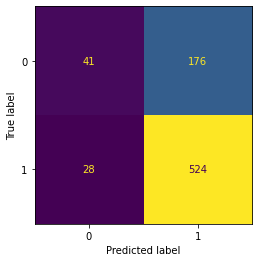

In [141]:
baseline_pcg_test_results['y_pred_val'] = 0
baseline_pcg_test_results['y_pred_val'] = baseline_pcg_test_results['y_pred_val'].astype('object')
baseline_pcg_test_results.at[0, 'y_pred_val']=[1 if i > 0.5 else 0 for i in baseline_pcg_test_results['prediction_test'].iloc[0] ]
base_pcg_cm = cm(baseline_pcg_test_results['y_true_val'].iloc[0], baseline_pcg_test_results['y_pred_val'].iloc[0])
disp = ConfusionMatrixDisplay(base_pcg_cm)
disp.plot(colorbar=False)
plt.savefig('cm_baseline_pcg_sw.png', dpi=400)

In [142]:
baseline_pcg_test_results

,params,fold_number,loss,acc_train,acc_val,epoch_val_losses,train_f1,train_acc,test_f1,test_acc,...,test_recall,y_true_train,y_true_val,prediction_train,prediction_test,train_group,test_group,params_str,setting,y_pred_val
0,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",-1,"[1.0653823614120483, 0.6314793825149536, 0.631...","[0.6190741658210754, 0.7094255685806274, 0.709...","[0.7243173122406006, 0.7360208034515381, 0.732...","[0.5908111333847046, 0.6036438345909119, 0.598...",0.851928,0.760178,0.837061,0.73472,...,0.949275,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[0.7315563], [0.65013254], [0.81372666], [0.8...","[[0.7414082], [0.66370577], [0.8220851], [0.70...",1 0 8 0 0 0 11 0 10 0 ....,3 0 0 0 2 0 1 0 4 0 ....,"{'batch_size': 32, 'epochs': 10, 'optimizer': ...",Baseline - PCG,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."


In [143]:
baseline_pcg_test_results_rw = get_record_wise_results(baseline_pcg_test_results)

baseline_pcg_test_results_rw[['record_roc_auc', 'record_recall', 'record_precision', 'record_accuracy', 'record_f1_score']]

,record_roc_auc,record_recall,record_precision,record_accuracy,record_f1_score
0,0.797373,0.965517,0.743363,0.737705,0.84


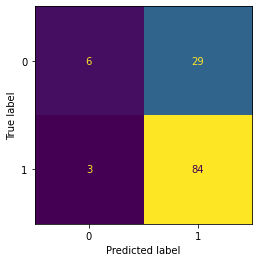

In [144]:
disp = ConfusionMatrixDisplay(baseline_pcg_test_results_rw['confusion_matrix'].iloc[0])
disp.plot(colorbar=False)
plt.savefig('cm_baseline_pcg.png', dpi=400)

## Baseline ECG

In [184]:
baseline_ecg_test_results = ['ecg_scratch27_09_2023__03_13_23test_results.pkl']


baseline_ecg_test_results = load_pickle_df(baseline_ecg_test_results)

baseline_ecg_test_results['setting'] = 'Baseline - ECG' 

#baseline_ecg_test_results[test_columns]
baseline_ecg_test_results[test_columns]

,setting,test_auc,test_recall,test_precision,test_acc,test_f1
0,Baseline - ECG,0.865124,0.875,0.860963,0.808843,0.867925


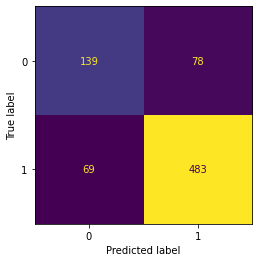

In [185]:
baseline_ecg_test_results['y_pred_val'] = 0
baseline_ecg_test_results['y_pred_val'] = baseline_ecg_test_results['y_pred_val'].astype('object')
baseline_ecg_test_results.at[0, 'y_pred_val']=[1 if i > 0.5 else 0 for i in baseline_ecg_test_results['prediction_test'].iloc[0] ]
baseline_ecg_cm = cm(baseline_ecg_test_results['y_true_val'].iloc[0], baseline_ecg_test_results['y_pred_val'].iloc[0])
disp = ConfusionMatrixDisplay(baseline_ecg_cm)
disp.plot(colorbar=False)
plt.savefig('cm_baseline_ecg_sw.png', dpi=400)

In [186]:
baseline_ecg_test_results_rw = get_record_wise_results(baseline_ecg_test_results)

baseline_ecg_test_results_rw[['record_roc_auc', 'record_recall', 'record_precision', 'record_accuracy', 'record_f1_score']]

,record_roc_auc,record_recall,record_precision,record_accuracy,record_f1_score
0,0.885057,0.885057,0.855556,0.811475,0.870056


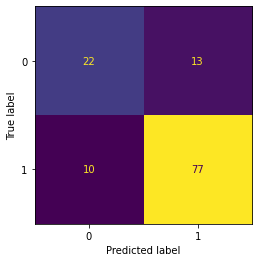

In [148]:
disp = ConfusionMatrixDisplay(baseline_ecg_test_results_rw['confusion_matrix'].iloc[0])
disp.plot(colorbar=False)
plt.savefig('cm_ecg_baseline.png', dpi=400)

## SETTING 1

In [149]:
setting1_test_results = ['ecg_pcg21_09_2023__09_49_57test_results_multimodal_vgg.pkl']

setting1_test_results = load_pickle_df(setting1_test_results)
setting1_test_results['params_str'].iloc[0]

setting1_test_results['setting'] = 'Setting 1' 

setting1_test_results[test_columns]


,setting,test_auc,test_recall,test_precision,test_acc,test_f1
0,Setting 1,0.859259,0.90942,0.831126,0.802341,0.868512


In [150]:
setting1_test_results_rw = get_record_wise_results(setting1_test_results)
setting1_test_results_rw[['record_roc_auc', 'record_recall', 'record_precision', 'record_accuracy', 'record_f1_score']]

,record_roc_auc,record_recall,record_precision,record_accuracy,record_f1_score
0,0.860755,0.931034,0.826531,0.811475,0.875676


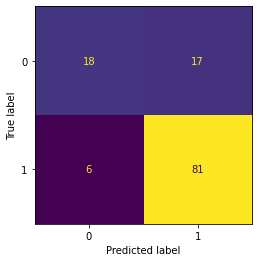

In [151]:
disp = ConfusionMatrixDisplay(setting1_test_results_rw['confusion_matrix'].iloc[0])
disp.plot(colorbar=False)
plt.savefig('cm_setting_1.png', dpi=400)

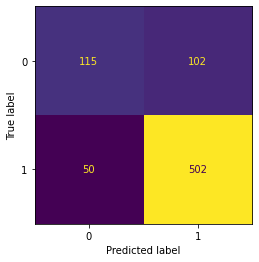

In [152]:
setting1_test_results['y_pred_val'] = 0
setting1_test_results['y_pred_val'] = setting1_test_results['y_pred_val'].astype('object')
setting1_test_results.at[0, 'y_pred_val']=[1 if i > 0.5 else 0 for i in setting1_test_results['prediction_test'].iloc[0] ]
setting1_cm = cm(setting1_test_results['y_true_val'].iloc[0], setting1_test_results['y_pred_val'].iloc[0])
disp = ConfusionMatrixDisplay(setting1_cm)
disp.plot(colorbar=False)
plt.savefig('cm_setting_1_sw.png', dpi=400)

## SETTING 2

In [153]:
setting2_test_results = ['ecg_pcg21_09_2023__09_08_49test_results_imagenet_multimodal_vgg.pkl']

setting2_test_results = load_pickle_df(setting2_test_results)
setting2_test_results['params_str'].iloc[0]

setting2_test_results['setting'] = 'Setting 2' 

setting2_test_results[test_columns]


,setting,test_auc,test_recall,test_precision,test_acc,test_f1
0,Setting 2,0.887702,0.92029,0.850921,0.827048,0.884247


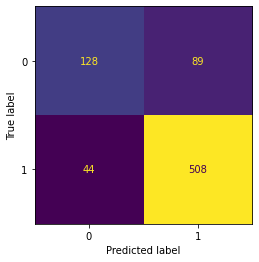

In [154]:
setting2_test_results['y_pred_val'] = 0
setting2_test_results['y_pred_val'] = setting2_test_results['y_pred_val'].astype('object')
setting2_test_results.at[0, 'y_pred_val']=[1 if i > 0.5 else 0 for i in setting2_test_results['prediction_test'].iloc[0] ]
setting2_cm = cm(setting2_test_results['y_true_val'].iloc[0], setting2_test_results['y_pred_val'].iloc[0])
disp = ConfusionMatrixDisplay(setting2_cm)
disp.plot(colorbar=False)
plt.savefig('cm_setting_2_sw.png', dpi=400)

In [155]:
setting2_test_results_rw = get_record_wise_results(setting2_test_results)
setting2_test_results_rw[['record_roc_auc', 'record_recall', 'record_precision', 'record_accuracy', 'record_f1_score']]

,record_roc_auc,record_recall,record_precision,record_accuracy,record_f1_score
0,0.912644,0.931034,0.84375,0.827869,0.885246


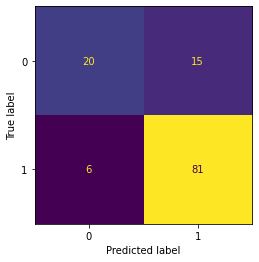

In [156]:
disp = ConfusionMatrixDisplay(setting2_test_results_rw['confusion_matrix'].iloc[0])
disp.plot(colorbar=False)
plt.savefig('cm_setting_2.png', dpi=400)

## SETTING 3

In [157]:
setting3_test_results = ['ecg_pcg27_09_2023__08_57_09test_results_finetuned_multimodal_vgg.pkl']

setting3_test_results = load_pickle_df(setting3_test_results)
setting3_test_results['params_str'].iloc[0]

setting3_test_results['setting'] = 'Setting 3' 

setting3_test_results[test_columns]

,setting,test_auc,test_recall,test_precision,test_acc,test_f1
0,Setting 3,0.808868,0.817029,0.847744,0.763329,0.832103


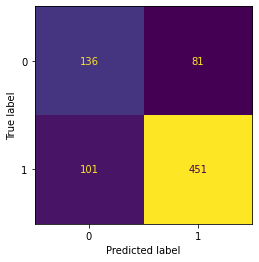

In [158]:
setting3_test_results['y_pred_val'] = 0
setting3_test_results['y_pred_val'] = setting3_test_results['y_pred_val'].astype('object')
setting3_test_results.at[0, 'y_pred_val']=[1 if i > 0.5 else 0 for i in setting3_test_results['prediction_test'].iloc[0] ]
setting3_cm = cm(setting3_test_results['y_true_val'].iloc[0], setting3_test_results['y_pred_val'].iloc[0])
disp = ConfusionMatrixDisplay(setting3_cm)
disp.plot(colorbar=False)
plt.savefig('cm_setting_3_sw.png', dpi=400)

In [159]:
setting3_test_results_rw = get_record_wise_results(setting3_test_results)
setting3_test_results_rw[['record_roc_auc', 'record_recall', 'record_precision', 'record_accuracy', 'record_f1_score']]

,record_roc_auc,record_recall,record_precision,record_accuracy,record_f1_score
0,0.83908,0.850575,0.860465,0.795082,0.855491


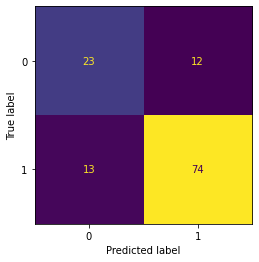

In [160]:
disp = ConfusionMatrixDisplay(setting3_test_results_rw['confusion_matrix'].iloc[0])
disp.plot(colorbar=False)
plt.savefig('cm_setting_3.png', dpi=400)

In [161]:
confusion_matrices = [base_pcg_cm, baseline_ecg_cm, setting1_cm, setting2_cm, setting3_cm]
cm_title = ['Baseline PCG', 'Baseline ECG', 'Setting 1', 'Setting 2', 'Setting 3']

In [162]:
base_pcg_cm

array([[ 41, 176],
       [ 28, 524]], dtype=int64)

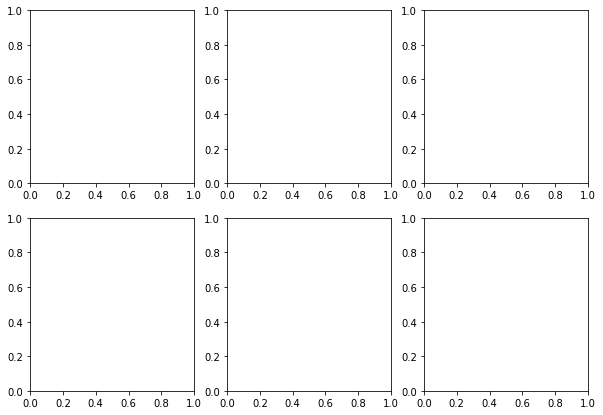

In [163]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))

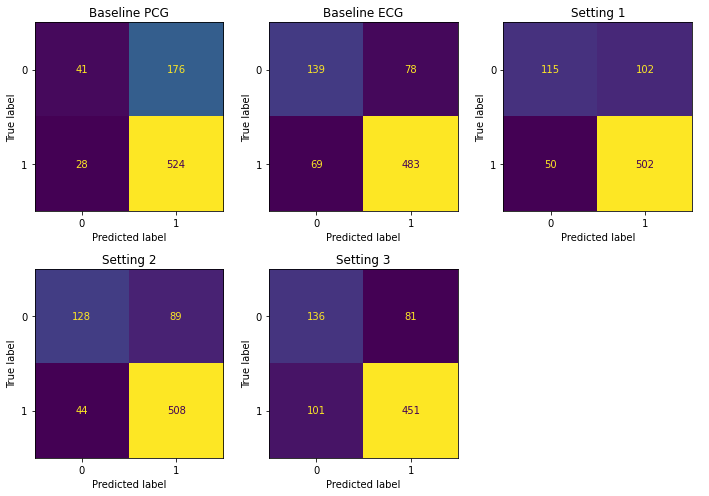

In [164]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between rows

for i, ax in enumerate(axes.flatten()):
    
    if i < len(confusion_matrices):
        disp = ConfusionMatrixDisplay(confusion_matrices[i])
        disp.plot(ax=ax, colorbar=False)
        #disp.plot()
        #ax.set_title(f'({chr(97 + i)})')  # This will label the subplots as (a), (b), (c), etc.
        disp.ax_.set_title(cm_title[i])
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('cm_sw.png', dpi = 1000)
plt.show()
plt.close()

In [165]:
confusion_matrices = [baseline_pcg_test_results_rw['confusion_matrix'].iloc[0], baseline_ecg_test_results_rw['confusion_matrix'].iloc[0], setting1_test_results_rw['confusion_matrix'].iloc[0], setting2_test_results_rw['confusion_matrix'].iloc[0], setting3_test_results_rw['confusion_matrix'].iloc[0]]
cm_title = ['Baseline PCG', 'Baseline ECG', 'Setting 1', 'Setting 2', 'Setting 3']

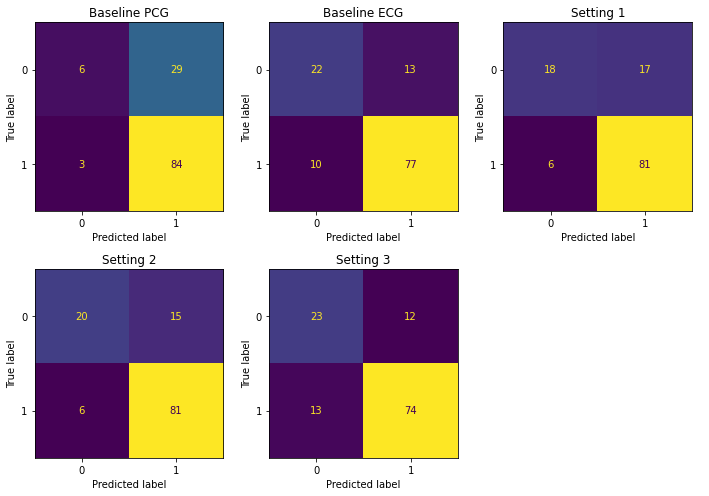

In [166]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
fig.subplots_adjust(hspace=0.5)  # Adjust the vertical spacing between rows

for i, ax in enumerate(axes.flatten()):
    
    if i < len(confusion_matrices):
        disp = ConfusionMatrixDisplay(confusion_matrices[i])
        disp.plot(ax=ax, colorbar=False)
        #disp.plot()
        #ax.set_title(f'({chr(97 + i)})')  # This will label the subplots as (a), (b), (c), etc.
        disp.ax_.set_title(cm_title[i])
    else:
        ax.axis('off')

plt.tight_layout()
plt.savefig('cm_rw.png', dpi = 1000)
plt.show()
plt.close()

In [167]:
baseline_pcg_test_results.columns

Index(['params', 'fold_number', 'loss', 'acc_train', 'acc_val',
       'epoch_val_losses', 'train_f1', 'train_acc', 'test_f1', 'test_acc',
       'train_auc', 'test_auc', 'train_precision', 'train_recall',
       'test_precision', 'test_recall', 'y_true_train', 'y_true_val',
       'prediction_train', 'prediction_test', 'train_group', 'test_group',
       'params_str', 'setting', 'y_pred_val', 'record_pr_auc',
       'record_true_values', 'record_wise_probs', 'record_f1_score',
       'record_accuracy', 'record_precision', 'record_recall',
       'confusion_matrix', 'record_roc_auc'],
      dtype='object')

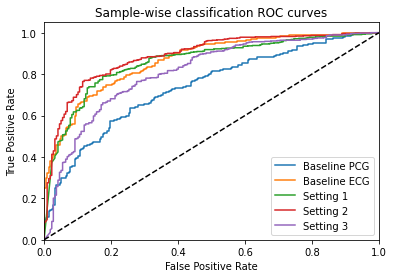

In [168]:
from sklearn.metrics import roc_curve


# Assuming df is your DataFrame and 'y_true' and 'y_pred' are the column names
fpr, tpr, thresholds = roc_curve(baseline_pcg_test_results['y_true_val'].iloc[0], baseline_pcg_test_results['prediction_test'].iloc[0])

plt.figure()
plt.plot(fpr, tpr, label='Baseline PCG')
fpr, tpr, thresholds = roc_curve(baseline_ecg_test_results['y_true_val'].iloc[0], baseline_ecg_test_results['prediction_test'].iloc[0])
plt.plot(fpr, tpr, label='Baseline ECG')
fpr, tpr, thresholds = roc_curve(setting1_test_results['y_true_val'].iloc[0], setting1_test_results['prediction_test'].iloc[0])
plt.plot(fpr, tpr, label='Setting 1')
fpr, tpr, thresholds = roc_curve(setting2_test_results['y_true_val'].iloc[0], setting2_test_results['prediction_test'].iloc[0])
plt.plot(fpr, tpr, label='Setting 2')
fpr, tpr, thresholds = roc_curve(setting3_test_results['y_true_val'].iloc[0], setting3_test_results['prediction_test'].iloc[0])
plt.plot(fpr, tpr, label='Setting 3')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Sample-wise classification ROC curves')
plt.legend(loc="lower right")
plt.savefig('roc_sw.png', dpi = 1000)
plt.show()
plt.close()


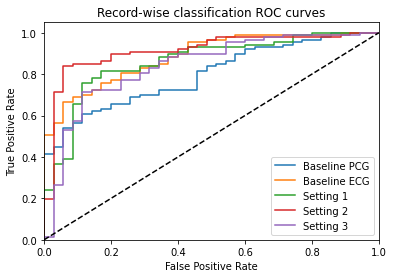

In [169]:
# Assuming df is your DataFrame and 'y_true' and 'y_pred' are the column names
fpr, tpr, thresholds = roc_curve(baseline_pcg_test_results_rw['record_true_values'].iloc[0], baseline_pcg_test_results_rw['record_wise_probs'].iloc[0])

plt.figure()
plt.plot(fpr, tpr, label='Baseline PCG')
fpr, tpr, thresholds = roc_curve(baseline_ecg_test_results_rw['record_true_values'].iloc[0], baseline_ecg_test_results_rw['record_wise_probs'].iloc[0])
plt.plot(fpr, tpr, label='Baseline ECG')
fpr, tpr, thresholds = roc_curve(setting1_test_results_rw['record_true_values'].iloc[0], setting1_test_results_rw['record_wise_probs'].iloc[0])
plt.plot(fpr, tpr, label='Setting 1')
fpr, tpr, thresholds = roc_curve(setting2_test_results_rw['record_true_values'].iloc[0], setting2_test_results_rw['record_wise_probs'].iloc[0])
plt.plot(fpr, tpr, label='Setting 2')
fpr, tpr, thresholds = roc_curve(setting3_test_results_rw['record_true_values'].iloc[0], setting3_test_results_rw['record_wise_probs'].iloc[0])
plt.plot(fpr, tpr, label='Setting 3')


plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Record-wise classification ROC curves')
plt.legend(loc="lower right")
plt.savefig('roc_rw.png', dpi = 1000)
plt.show()
plt.close()


In [170]:
baseline_ecg_test_results_rw.columns

Index(['params', 'fold_number', 'loss', 'acc_train', 'acc_val',
       'epoch_val_losses', 'train_f1', 'train_acc', 'test_f1', 'test_acc',
       'train_auc', 'test_auc', 'train_precision', 'train_recall',
       'test_precision', 'test_recall', 'y_true_train', 'y_true_val',
       'prediction_train', 'prediction_test', 'train_group', 'test_group',
       'params_str', 'setting', 'y_pred_val', 'record_pr_auc',
       'record_true_values', 'record_wise_probs', 'record_f1_score',
       'record_accuracy', 'record_precision', 'record_recall',
       'confusion_matrix', 'record_roc_auc'],
      dtype='object')

In [171]:
fpr, tpr, thresholds = roc_curve(setting2_test_results['y_true_val'].iloc[0], setting2_test_results['prediction_test'].iloc[0])


In [172]:
x = tpr - fpr

In [173]:
x.argmax()

80

In [174]:
thresholds[80]

0.9711908

In [175]:
np.sqrt(tpr*(1-fpr)).argmax()

80

In [176]:
setting2_test_results['y_true_val'].iloc[0], setting2_test_results['prediction_test'].iloc[0]

([1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,

In [95]:
pred_threshold =0.9711908

y_pred = [1 if i > pred_threshold  else 0 for i in setting2_test_results['prediction_test'].iloc[0]]

In [113]:
recall_score(setting2_test_results['y_true_val'].iloc[0], y_pred)

0.7681159420289855

In [73]:
y_pred_rw = [1 if i > pred_threshold  else 0 for i in setting2_test_results['record_wise_probs'].iloc[0]]

In [76]:
_score(setting2_test_results['record_true_values'].iloc[0], y_pred_rw)

0.6436781609195402

In [77]:
imagenet_results_df_full

,params,fold_number,loss,acc_train,acc_val,epoch_val_losses,train_f1,train_acc,test_f1,test_acc,...,train_recall,test_precision,test_recall,y_true_train,y_true_val,prediction_train,prediction_test,train_group,test_group,params_str
0,"{'batch_size': 8, 'epochs': 20, 'optimizer': '...",1,"[1.826038122177124, 0.6698590517044067, 0.5614...","[0.6385205984115601, 0.687369167804718, 0.7362...","[0.6499999761581421, 0.6666666865348816, 0.630...","[0.678627073764801, 0.6040463447570801, 0.6480...",0.986987,0.981856,0.828753,0.775000,...,0.975272,0.924528,0.750958,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[0.9985806], [0.99634165], [0.99959964], [0.9...","[[0.0024233102], [0.0034942199], [0.03580232],...",629 100 630 100 631 100 632 100 63...,5 0 6 0 4 0 11 0 3 ...,"{'batch_size': 8, 'epochs': 20, 'optimizer': '..."
1,"{'batch_size': 8, 'epochs': 20, 'optimizer': '...",2,"[1.6718497276306152, 0.7536489367485046, 0.578...","[0.6126760840415955, 0.6380281448364258, 0.701...","[0.5442359447479248, 0.6729222536087036, 0.718...","[0.7586380839347839, 0.5922992825508118, 0.561...",0.993606,0.990845,0.882591,0.844504,...,0.987292,0.889796,0.875502,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.9989249], [0.99958843], [0.9993931], [0.99...","[[2.0961503e-08], [6.1689417e-07], [1.11930385...",5 0 6 0 4 0 11 0 3 0 ....,683 108 684 108 686 108 685 108 68...,"{'batch_size': 8, 'epochs': 20, 'optimizer': '..."
2,"{'batch_size': 8, 'epochs': 20, 'optimizer': '...",3,"[1.8770923614501953, 0.8258300423622131, 0.619...","[0.6106870174407959, 0.6800832748413086, 0.746...","[0.6903409361839294, 0.7357954382896423, 0.732...","[0.5941123962402344, 0.5270755290985107, 0.542...",0.999009,0.998612,0.886486,0.821023,...,0.998020,0.839590,0.938931,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.9998319], [0.9999962], [0.9999974], [0.999...","[[0.99974483], [0.9988078], [0.99890184], [0.9...",5 0 6 0 4 0 11 0 3 ...,629 100 630 100 631 100 632 100 63...,"{'batch_size': 8, 'epochs': 20, 'optimizer': '..."
3,"{'batch_size': 8, 'epochs': 20, 'optimizer': '...",4,"[1.2450379133224487, 0.6326704621315002, 0.518...","[0.5967966318130493, 0.6838440299034119, 0.728...","[0.686274528503418, 0.7591036558151245, 0.8039...","[0.5838391184806824, 0.5418087840080261, 0.481...",0.996543,0.995125,0.869198,0.826331,...,0.993110,0.944954,0.804688,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.9999914], [0.999998], [0.9999994], [1.0], ...","[[3.8310827e-05], [0.014153006], [0.009727648]...",5 0 6 0 4 0 11 0 3 0 ....,636 101 637 101 638 101 639 101 64...,"{'batch_size': 8, 'epochs': 20, 'optimizer': '..."
4,"{'batch_size': 8, 'epochs': 20, 'optimizer': '...",5,"[1.6776071786880493, 0.8434113264083862, 0.618...","[0.6158113479614258, 0.6775311827659607, 0.718...","[0.680911660194397, 0.7008547186851501, 0.7378...","[0.636167585849762, 0.5799840688705444, 0.5305...",0.968907,0.957004,0.806378,0.757835,...,0.939689,0.907692,0.725410,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.99992], [0.9999963], [0.9999999], [1.0], [...","[[0.07695185], [0.0012869297], [0.022722954], ...",5 0 6 0 4 0 11 0 3 0 ....,643 102 644 102 645 102 646 102 64...,"{'batch_size': 8, 'epochs': 20, 'optimizer': '..."


In [79]:
imagenet_results_df_full.columns

Index(['params', 'fold_number', 'loss', 'acc_train', 'acc_val',
       'epoch_val_losses', 'train_f1', 'train_acc', 'test_f1', 'test_acc',
       'train_auc', 'test_auc', 'train_precision', 'train_recall',
       'test_precision', 'test_recall', 'y_true_train', 'y_true_val',
       'prediction_train', 'prediction_test', 'train_group', 'test_group',
       'params_str'],
      dtype='object')

In [104]:
# Create a function to calculate G-mean
def calculate_g_mean(y_true, y_pred, threshold):
    # Apply the threshold to the predictions
    y_pred_thresholded = (y_pred >= threshold).astype(int).flatten()
    print(y_pred_thresholded)
    y_true = np.array([1 if i > 0.99 else 0 for i in y_true])
    print (y_true)
    #print(y_pred_thresholded)
    # Calculate Sensitivity and Specificity with checks for division by zero
    true_positives = np.sum((y_true == 1) & (y_pred_thresholded == 1))
    false_negatives = np.sum((y_true == 1) & (y_pred_thresholded == 0))
    true_negatives = np.sum((y_true == 0) & (y_pred_thresholded == 0))
    false_positives = np.sum((y_true == 0) & (y_pred_thresholded == 1))
    
    print (true_positives, false_negatives, true_negatives, false_positives)
    # Check for division by zero and handle it gracefully
    if true_positives + false_negatives == 0:
        sensitivity = 0.0
    else:
        sensitivity = true_positives / (true_positives + false_negatives)
    
    if true_negatives + false_positives == 0:
        specificity = 0.0
    else:
        specificity = true_negatives / (true_negatives + false_positives)
    
    # Calculate G-mean
    g_mean = np.sqrt(sensitivity * specificity)
    
    return g_mean

# Calculate the average G-mean for each threshold across the five folds
average_g_means = []
for threshold in thresholds:
    g_means = []
    for fold in range(5):
        fold_data = imagenet_results_df_full.iloc[fold]
        y_true_fold = fold_data['y_true_val']
        y_pred_fold = fold_data['prediction_test']
        
        g_mean = calculate_g_mean(y_true_fold, y_pred_fold, threshold)
        g_means.append(g_mean)
    
    average_g_mean = np.mean(g_means)
    average_g_means.append(average_g_mean)

# Find the threshold that maximizes the average G-mean
optimal_threshold = thresholds[np.argmax(average_g_means)]
max_average_g_mean = max(average_g_means)

print(f"Optimal Threshold: {optimal_threshold}")
print(f"Maximum Average G-mean: {max_average_g_mean}")

[0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0
 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0]
[1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0

 0 0 0]
227 22 94 30
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0]
219 30 97 27
[1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 0 0 0]
217 32 97 27
[1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
238 24 50 40
[0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0
 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 0
 0 0 1 1 1 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0
 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0

 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1]
167 94 85 14
[0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1
 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1
 0 0 0]
[0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 

In [84]:
average_g_means

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [95]:
imagenet_results_df_full['prediction_test']

0    [[0.0024233102], [0.0034942199], [0.03580232],...
1    [[2.0961503e-08], [6.1689417e-07], [1.11930385...
2    [[0.99974483], [0.9988078], [0.99890184], [0.9...
3    [[3.8310827e-05], [0.014153006], [0.009727648]...
4    [[0.07695185], [0.0012869297], [0.022722954], ...
Name: prediction_test, dtype: object